In [1]:
# Import all required libraries
import pandas as pd
import numpy as np
import pingouin as pg
from pathlib import Path
from scipy import stats
from scipy.stats import spearmanr
import matplotlib.pyplot as plt
import seaborn as sns
import os.path as op
import re
import nibabel as nib

# Additional imports for neuroimaging and atlas processing
from nilearn import datasets, masking, input_data, plotting
from nilearn.maskers import NiftiMapsMasker
from nilearn.connectome import ConnectivityMeasure
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

/var/folders/w7/tr80j6dx7kz1xqvddnxtqtzr0000gn/T/ipykernel_37447/1634084641.py:15: DeprecationWarning: The import path 'nilearn.input_data' is deprecated in version 0.9. Importing from 'nilearn.input_data' will be possible at least until release 0.13.0. Please import from 'nilearn.maskers' instead.
  from nilearn import datasets, masking, input_data, plotting


In [2]:
# Setup directories and plotting theme
RELI_DIR = Path("dset/derivatives/caps/interrater")
FIGURES_DIR = Path("dset/derivatives/figures")
# will use loop later to run over all subjects
OUT_DIR = Path("dset/derivatives/caps/emotion-correlation")
OUT_DIR.mkdir(parents=True, exist_ok=True)


In [3]:
# Define all runs for each participant and episode
participant_data = {
    "sub-Blossom": {
        "S01E01": [1, 2, 3],           # Episode 1 has 3 runs
        "S01E02": [1, 2, 3, 4, 5, 6, 7], # Episode 2 has 7 runs
    },
    "sub-Bubbles": {
        "S01E01": [1, 2, 3],
        "S01E02": [1, 2, 3, 4, 5, 6, 7],
        "S01E03": [1, 2, 3, 4, 5, 6],     # Add other participants as needed
        "S01E04": [1, 2, 3, 4, 5]
    },
    "sub-Buttercup": {
        "S01E01": [1, 2, 3],
        "S01E02": [1, 2, 3, 4, 5, 6, 7],
        "S01E03": [1, 2, 3, 4, 5, 6],
        "S01E04": [1, 2, 3, 4, 5]
}
}

In [4]:
# Define CAP masks to process
# Define CAP masks to process
cap_masks = []
for cap_num in range(1, 5):  # CAPs 1-4
    for polarity in ['pos', 'neg']:
        mask_path = Path(f"dset/derivatives/caps/caps_masks/sub-Blossom_zscore-weighted-0_CAP_{cap_num}_{polarity}.nii.gz")
        if mask_path.exists():
            cap_masks.append({
                'cap_num': cap_num,
                'polarity': polarity,
                'path': mask_path,
                'name': f"CAP{cap_num}_{polarity}"
            })

print(f"Found {len(cap_masks)} CAP masks to process:")
for mask_info in cap_masks:
    print(f"  - {mask_info['name']}: {mask_info['path']}")

removed_clips_df = pd.read_csv(Path("dset/derivatives/annotations/removed_clips_log.csv"))

# Initialize storage for all participant-episode combinations
all_combined_timeseries = {}

# Process each participant-episode combination
for sub_id, episodes in participant_data.items():
    print(f"\n{'='*80}")
    print(f"PROCESSING {sub_id}")
    print(f"{'='*80}")
    
    for episode_key, run_numbers in episodes.items():
        # Handle both episode naming conventions
        if episode_key.startswith('S01E'):
            ep_num = int(episode_key[-2:])  # Extract from S01E02
        else:
            ep_num = int(episode_key.split('_')[1])  # Extract from episode_2
        
        output_csv = OUT_DIR / f"{sub_id}_{episode_key}_all_caps_timeseries.csv"
        if output_csv.exists():
            print(f"\nSkipping {sub_id} {episode_key} — CSV already exists: {output_csv}")
            continue

        print(f"\n{'='*60}")
        print(f"Processing {episode_key} with {len(run_numbers)} runs...")
        print(f"{'='*60}")
        
        # Get excluded clips for this episode
        excluded_clips_episode = removed_clips_df[removed_clips_df['episode'] == episode_key]['episode_position'].tolist()
        print(f"Found {len(excluded_clips_episode)} excluded clips for {episode_key}: {excluded_clips_episode[:10] if len(excluded_clips_episode) > 10 else excluded_clips_episode}...")
        
        participant_episode_key = f"{sub_id}_{episode_key}"
        all_cap_timeseries = {}
        
        for mask_info in cap_masks:
            print(f"\n  Processing {mask_info['name']}...")
            
            mask_img = nib.load(mask_info['path'])
            mask_data = mask_img.get_fdata()

            caps_masker = NiftiMapsMasker(
                maps_img=mask_img,
                standardize=True,
                memory='nilearn_cache',
                mask_type="whole-brain",
                verbose=0
            )
            
            participant_timeseries = []
            all_clip_positions = []
            
            for run_num in run_numbers:
                print(f"    Processing run {run_num}...")
                
                TASK_DIR = Path(f"dset/{sub_id}/ses-{ep_num:02d}/func") 
                task_filename = f"{sub_id}_ses-{ep_num:02d}_task-strangerthings_run-{run_num}_part-mag_space-MNI152NLin2009cAsym_res-2_desc-preproc_bold.nii.gz"
                task_filepath = TASK_DIR / task_filename

                time_series = caps_masker.fit_transform(task_filepath)
                        
                if time_series.shape[0] > 5:
                    time_series_trimmed = time_series[5:]
                else:
                    print(f"    WARNING: Run has only {time_series.shape[0]} TRs, cannot remove 5 TRs!")
                    time_series_trimmed = time_series
                
                if run_num == 1:
                    run_start_clip = 1
                else:
                    run_start_clip = len(all_clip_positions) + 1
                
                tr_positions = list(range(run_start_clip, run_start_clip + time_series_trimmed.shape[0]))
                all_clip_positions.extend(tr_positions)
                participant_timeseries.append(time_series_trimmed)

            if participant_timeseries:
                participant_matrix = np.vstack(participant_timeseries)
                exclude_mask = np.array([pos in excluded_clips_episode for pos in all_clip_positions])
                keep_mask = ~exclude_mask
                excluded_count = np.sum(exclude_mask)
                
                if np.any(keep_mask):
                    participant_matrix_filtered = participant_matrix[keep_mask]
                else:
                    print("Warning: All TRs would be excluded! Using original matrix.")
                    participant_matrix_filtered = participant_matrix
                
                all_cap_timeseries[mask_info['name']] = participant_matrix_filtered.flatten()
                print(f"    {mask_info['name']}: {participant_matrix_filtered.shape} -> {len(participant_matrix_filtered.flatten())} timepoints")
        
        if all_cap_timeseries:
            timeseries_lengths = [len(ts) for ts in all_cap_timeseries.values()]
            min_length = min(timeseries_lengths) if timeseries_lengths else 0
            
            if len(set(timeseries_lengths)) > 1:
                print(f"  Warning: Different timeseries lengths found: {set(timeseries_lengths)}")
                print(f"  Truncating all to minimum length: {min_length}")
                
            combined_df_data = {cap_name: ts[:min_length] for cap_name, ts in all_cap_timeseries.items()}
            combined_df = pd.DataFrame(combined_df_data)
            
            combined_df.to_csv(output_csv, index=False)
            print(f"\nSaved combined timeseries CSV: {output_csv}")
            print(f"Shape: {combined_df.shape} (timepoints x CAPs)")
            print(f"Columns: {list(combined_df.columns)}")
            
            all_combined_timeseries[participant_episode_key] = combined_df
            
            exclusion_info = {
                'episode': episode_key,
                'participant': sub_id,
                'runs_processed': run_numbers,
                'original_trs_before_trimming': int(participant_matrix.shape[0]) + (len(run_numbers) * 5),
                'trs_removed_for_t1_equilibration': len(run_numbers) * 5,
                'original_trs_after_trimming': int(participant_matrix.shape[0]),
                'excluded_trs': int(excluded_count),
                'final_trs': min_length,
                'excluded_positions': [float(pos) for pos in excluded_clips_episode],
                'cap_columns': list(combined_df.columns)
            }
            
            exclusion_file = OUT_DIR / f"{sub_id}_{episode_key}_exclusion_info.json"
            with open(exclusion_file, 'w') as f:
                json.dump(exclusion_info, f, indent=2)
            print(f"Saved exclusion info: {exclusion_file}")

print(f"\n{'='*80}")
print("ALL PROCESSING COMPLETE")
print(f"{'='*80}")
print(f"Processed {len(all_combined_timeseries)} participant-episode combinations:")
for key, df in all_combined_timeseries.items():
    print(f"  {key}: {df.shape[0]} timepoints × {df.shape[1]} CAPs")
    print(f"    Columns: {list(df.columns)}")


Found 8 CAP masks to process:
  - CAP1_pos: dset/derivatives/caps/caps_masks/sub-Blossom_zscore-weighted-0_CAP_1_pos.nii.gz
  - CAP1_neg: dset/derivatives/caps/caps_masks/sub-Blossom_zscore-weighted-0_CAP_1_neg.nii.gz
  - CAP2_pos: dset/derivatives/caps/caps_masks/sub-Blossom_zscore-weighted-0_CAP_2_pos.nii.gz
  - CAP2_neg: dset/derivatives/caps/caps_masks/sub-Blossom_zscore-weighted-0_CAP_2_neg.nii.gz
  - CAP3_pos: dset/derivatives/caps/caps_masks/sub-Blossom_zscore-weighted-0_CAP_3_pos.nii.gz
  - CAP3_neg: dset/derivatives/caps/caps_masks/sub-Blossom_zscore-weighted-0_CAP_3_neg.nii.gz
  - CAP4_pos: dset/derivatives/caps/caps_masks/sub-Blossom_zscore-weighted-0_CAP_4_pos.nii.gz
  - CAP4_neg: dset/derivatives/caps/caps_masks/sub-Blossom_zscore-weighted-0_CAP_4_neg.nii.gz

PROCESSING sub-Blossom

Skipping sub-Blossom S01E01 — CSV already exists: dset/derivatives/caps/emotion-correlation/sub-Blossom_S01E01_all_caps_timeseries.csv

Skipping sub-Blossom S01E02 — CSV already exists: dset/de

In [5]:
PLOT_ABS_R_THRESHOLD = 0.6  # only plot when |rho| > 0.6

def passes_threshold(rho, thr=PLOT_ABS_R_THRESHOLD):
    # Return True only if rho is finite and above threshold in magnitude
    return np.isfinite(rho) and (abs(rho) > thr)

In [6]:
# Plot CAP weighted timeseries with emotion ratings using combined CSV files
print("Loading combined CAP timeseries files for plotting...")

for sub_id, episodes in participant_data.items():
    print(f"\n{'='*80}")
    print(f"PLOTTING {sub_id}")
    print(f"{'='*80}")

    for episode_key, run_numbers in episodes.items():
        # Handle both episode naming conventions
        if episode_key.startswith('S01E'):
            ep_num = int(episode_key[-2:])  # Extract from S01E02
        else:
            ep_num = int(episode_key.split('_')[1])  # Extract from episode_2
        
        print(f"\n{'='*60}")
        print(f"Processing {episode_key}")
        print(f"{'='*60}")

        # Load combined CAP timeseries data
        combined_csv_path = OUT_DIR / f"{sub_id}_{episode_key}_all_caps_timeseries.csv"
        emotion_csv_path = RELI_DIR / f"S01E{ep_num:02d}_avg.csv"
        
        if not combined_csv_path.exists():
            print(f"Warning: Combined CAP data not found at {combined_csv_path}")
            continue
            
        if not emotion_csv_path.exists():
            print(f"Warning: Emotion data not found at {emotion_csv_path}")
            continue
        
        # Load the data
        caps_df = pd.read_csv(combined_csv_path)
        emotion_df = pd.read_csv(emotion_csv_path)
        
        print(f"Loaded CAP data: {caps_df.shape} (timepoints x CAPs)")
        print(f"CAP columns: {list(caps_df.columns)}")
        print(f"Loaded emotion data: {emotion_df.shape}")
        
        # Get emotion data
        valence = emotion_df['valence']
        arousal = emotion_df['arousal']
        
        # Ensure same length across all data
        min_length = min(len(valence), len(arousal), len(caps_df))
        valence = valence[:min_length]
        arousal = arousal[:min_length]
        caps_df_trimmed = caps_df.iloc[:min_length]
        
        print(f"Using {min_length} timepoints for analysis")
        
        # Plot each CAP column
        for cap_name in caps_df.columns:
            print(f"\n{'='*50}")
            print(f"Plotting {cap_name}")
            print(f"{'='*50}")
            
            # Get CAP timeseries for this column
            cap_timeseries = caps_df_trimmed[cap_name]
            
            # Calculate correlations for display
            val_corr, val_p = spearmanr(cap_timeseries, valence)
            aro_corr, aro_p = spearmanr(cap_timeseries, arousal)
            
            if not (passes_threshold(val_corr) or passes_threshold(aro_corr)):
                # Format safely even if NaN
                val_str = "nan" if not np.isfinite(val_corr) else f"{val_corr:.3f}"
                aro_str = "nan" if not np.isfinite(aro_corr) else f"{aro_corr:.3f}"
                print(f"    Skipping {cap_name} (|ρ_val|={val_str}, |ρ_aro|={aro_str} ≤ {PLOT_ABS_R_THRESHOLD})")
                continue

            # Create the plot
            fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 12))
            
            # Define colors
            colors = ['#CF9397', "#606933", '#E5D28E']
            
            # Valence plot
            ax1.axhspan(1, 4, alpha=0.1, color='red', zorder=0)
            ax1.axhspan(4, 7, alpha=0.1, color='green', zorder=0)
            
            # Plot valence ratings
            ax1.plot(range(len(valence)), valence, color=colors[0], marker='o', markersize=4, 
                     linewidth=2, alpha=0.8, label='Valence Ratings')
            
            # Plot CAP weighted timeseries on secondary y-axis
            ax1_twin = ax1.twinx()
            ax1_twin.plot(range(len(cap_timeseries)), cap_timeseries, color=colors[1], marker='s', markersize=4, 
                          linewidth=2, alpha=0.8, label=f'{cap_name} Weighted')
            
            ax1.set_title(f'{sub_id} {episode_key} - Valence vs {cap_name} Weighted', fontsize=16, fontweight='bold')
            ax1.set_xlabel(f'Clips ({len(valence)} total clips after exclusions)', fontsize=12)
            ax1.set_ylabel('Valence Rating', fontsize=12, color=colors[0])
            ax1_twin.set_ylabel(f'{cap_name} Weighted', fontsize=12, color=colors[1])
            ax1.set_ylim(0, 8)
            
            # Add reference lines for valence
            ax1.axhline(y=1, color='red', linestyle='--', alpha=0.7, linewidth=2)
            ax1.axhline(y=4, color='gray', linestyle='--', alpha=0.7, linewidth=2)
            ax1.axhline(y=7, color='green', linestyle='--', alpha=0.7, linewidth=2)
            
            # Add text labels
            x_right = ax1.get_xlim()[1]
            ax1.text(x_right, 1, 'Negative Valence', ha='left', va='bottom', fontsize=10, color='red')
            ax1.text(x_right, 4, 'Neutral', ha='left', va='bottom', fontsize=10, color='gray')
            ax1.text(x_right, 7, 'Positive Valence', ha='left', va='bottom', fontsize=10, color='green')
            
            # Combined legend
            lines1, labels1 = ax1.get_legend_handles_labels()
            lines2, labels2 = ax1_twin.get_legend_handles_labels()
            ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper right')
            
            # Add correlation results
            stats_text = [f"Spearman ρ: {val_corr:.3f}"]
            p_str = f"{val_p:.3f}" if val_p >= 0.001 else "<0.001"
            stats_text.append(f"p: {p_str}")
            
            ax1.text(0.02, 0.98, '\n'.join(stats_text), transform=ax1.transAxes,
                     fontsize=11, verticalalignment='top', horizontalalignment='left',
                     bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.8))

            # Arousal plot  
            # Plot arousal ratings
            ax2.plot(range(len(arousal)), arousal, color=colors[0], marker='o', markersize=4, 
                     linewidth=2, alpha=0.8, label='Arousal Ratings')
            
            # Plot CAP weighted timeseries on secondary y-axis
            ax2_twin = ax2.twinx()
            ax2_twin.plot(range(len(cap_timeseries)), cap_timeseries, color=colors[1], marker='s', markersize=4, 
                          linewidth=2, alpha=0.8, label=f'{cap_name} Weighted')
            
            ax2.set_title(f'{sub_id} {episode_key} - Arousal vs {cap_name} Weighted', fontsize=16, fontweight='bold')
            ax2.set_xlabel(f'Clips ({len(arousal)} total clips after exclusions)', fontsize=12)
            ax2.set_ylabel('Arousal Rating', fontsize=12, color=colors[0])
            ax2_twin.set_ylabel(f'{cap_name} Weighted', fontsize=12, color=colors[1])
            ax2.set_ylim(0, 8)
            
            # Add reference lines for arousal
            ax2.axhline(y=1, color='black', linestyle='--', alpha=0.7, linewidth=2)
            ax2.axhline(y=7, color='black', linestyle='--', alpha=0.7, linewidth=2)
            
            # Add text labels
            x_right = ax2.get_xlim()[1]
            ax2.text(x_right, 1, 'Low Arousal', ha='left', va='bottom', fontsize=10, color='black')
            ax2.text(x_right, 7, 'High Arousal', ha='left', va='bottom', fontsize=10, color='black')
            
            # Combined legend
            lines1, labels1 = ax2.get_legend_handles_labels()
            lines2, labels2 = ax2_twin.get_legend_handles_labels()
            ax2.legend(lines1 + lines2, labels1 + labels2, loc='upper right')
            
            # Add correlation results
            stats_text = [f"Spearman ρ: {aro_corr:.3f}"]
            p_str = f"{aro_p:.3f}" if aro_p >= 0.001 else "<0.001"
            stats_text.append(f"p: {p_str}")
            
            ax2.text(0.02, 0.98, '\n'.join(stats_text), transform=ax2.transAxes,
                     fontsize=11, verticalalignment='top', horizontalalignment='left',
                     bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.8))

            plt.tight_layout()
            
            # Save figure with CAP name
            figure_filename = f"{sub_id}_{episode_key}_{cap_name}_emotion_correlation.png"
            figure_path = FIGURES_DIR / figure_filename
            fig.savefig(figure_path, dpi=300, bbox_inches='tight', facecolor='white')
            print(f"Figure saved: {figure_path}")
            
            plt.show()
            
            print(f"Data lengths: CAP={len(cap_timeseries)}, Valence={len(valence)}, Arousal={len(arousal)}")
            print(f"Correlations: Valence r={val_corr:.3f} (p={val_p:.3f}), Arousal r={aro_corr:.3f} (p={aro_p:.3f})")

print(f"\n{'='*80}")
print("ALL PLOTTING COMPLETE")
print(f"{'='*80}")

Loading combined CAP timeseries files for plotting...

PLOTTING sub-Blossom

Processing S01E01
Loaded CAP data: (801, 8) (timepoints x CAPs)
CAP columns: ['CAP1_pos', 'CAP1_neg', 'CAP2_pos', 'CAP2_neg', 'CAP3_pos', 'CAP3_neg', 'CAP4_pos', 'CAP4_neg']
Loaded emotion data: (801, 4)
Using 801 timepoints for analysis

Plotting CAP1_pos
    Skipping CAP1_pos (|ρ_val|=-0.141, |ρ_aro|=0.256 ≤ 0.6)

Plotting CAP1_neg
    Skipping CAP1_neg (|ρ_val|=-0.023, |ρ_aro|=0.176 ≤ 0.6)

Plotting CAP2_pos
    Skipping CAP2_pos (|ρ_val|=0.002, |ρ_aro|=-0.225 ≤ 0.6)

Plotting CAP2_neg
    Skipping CAP2_neg (|ρ_val|=0.103, |ρ_aro|=-0.219 ≤ 0.6)

Plotting CAP3_pos
    Skipping CAP3_pos (|ρ_val|=nan, |ρ_aro|=nan ≤ 0.6)

Plotting CAP3_neg
    Skipping CAP3_neg (|ρ_val|=0.005, |ρ_aro|=0.019 ≤ 0.6)

Plotting CAP4_pos
    Skipping CAP4_pos (|ρ_val|=-0.005, |ρ_aro|=-0.009 ≤ 0.6)

Plotting CAP4_neg
    Skipping CAP4_neg (|ρ_val|=nan, |ρ_aro|=nan ≤ 0.6)

Processing S01E02
Loaded CAP data: (2004, 8) (timepoints x CAP

/var/folders/w7/tr80j6dx7kz1xqvddnxtqtzr0000gn/T/ipykernel_37447/3835811828.py:62: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  val_corr, val_p = spearmanr(cap_timeseries, valence)
/var/folders/w7/tr80j6dx7kz1xqvddnxtqtzr0000gn/T/ipykernel_37447/3835811828.py:63: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  aro_corr, aro_p = spearmanr(cap_timeseries, arousal)
/var/folders/w7/tr80j6dx7kz1xqvddnxtqtzr0000gn/T/ipykernel_37447/3835811828.py:62: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  val_corr, val_p = spearmanr(cap_timeseries, valence)
/var/folders/w7/tr80j6dx7kz1xqvddnxtqtzr0000gn/T/ipykernel_37447/3835811828.py:63: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  aro_corr, aro_p = spearmanr(cap_timeseries, arousal)


Processing CAP timeseries by individual runs using combined data...

PLOTTING sub-Blossom - BY RUNS

Processing S01E01 - Individual Runs
Loaded CAP data: (801, 8) (timepoints x CAPs)
Loaded emotion data with run info: (801, 4)
Available runs in emotion data: ['S01E01R01', 'S01E01R02', 'S01E01R03']
Using 801 timepoints for analysis

Processing S01E01 - Run 1
    Found 298 clips for run S01E01R01
    Run 1 data: 298 valence, 298 arousal, 298 CAP timepoints
    Skipping CAP1_pos (|ρ_val|=-0.413, |ρ_aro|=0.498 ≤ 0.6)
    Skipping CAP1_neg (|ρ_val|=-0.374, |ρ_aro|=0.430 ≤ 0.6)
    Skipping CAP2_pos (|ρ_val|=0.408, |ρ_aro|=-0.482 ≤ 0.6)
    Skipping CAP2_neg (|ρ_val|=0.323, |ρ_aro|=-0.412 ≤ 0.6)
    Skipping CAP3_pos (|ρ_val|=nan, |ρ_aro|=nan ≤ 0.6)
    Skipping CAP3_neg (|ρ_val|=-0.109, |ρ_aro|=0.110 ≤ 0.6)
    Skipping CAP4_pos (|ρ_val|=0.099, |ρ_aro|=-0.093 ≤ 0.6)
    Skipping CAP4_neg (|ρ_val|=nan, |ρ_aro|=nan ≤ 0.6)

Processing S01E01 - Run 2
    Found 276 clips for run S01E01R02
    Ru

/var/folders/w7/tr80j6dx7kz1xqvddnxtqtzr0000gn/T/ipykernel_37447/495858956.py:76: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  val_corr, val_p = spearmanr(cap_timeseries, run_valence)
/var/folders/w7/tr80j6dx7kz1xqvddnxtqtzr0000gn/T/ipykernel_37447/495858956.py:77: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  aro_corr, aro_p = spearmanr(cap_timeseries, run_arousal)
/var/folders/w7/tr80j6dx7kz1xqvddnxtqtzr0000gn/T/ipykernel_37447/495858956.py:76: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  val_corr, val_p = spearmanr(cap_timeseries, run_valence)
/var/folders/w7/tr80j6dx7kz1xqvddnxtqtzr0000gn/T/ipykernel_37447/495858956.py:77: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  aro_corr, aro_p = spearmanr(cap_timeseries, run_arousal)
/var/folders/w7/tr80j6dx7kz1xqvddnxtqtzr0000gn/T/ipykernel_3

    Figure saved: dset/derivatives/figures/sub-Bubbles_S01E02_run7_CAP1_pos_emotion_correlation.png


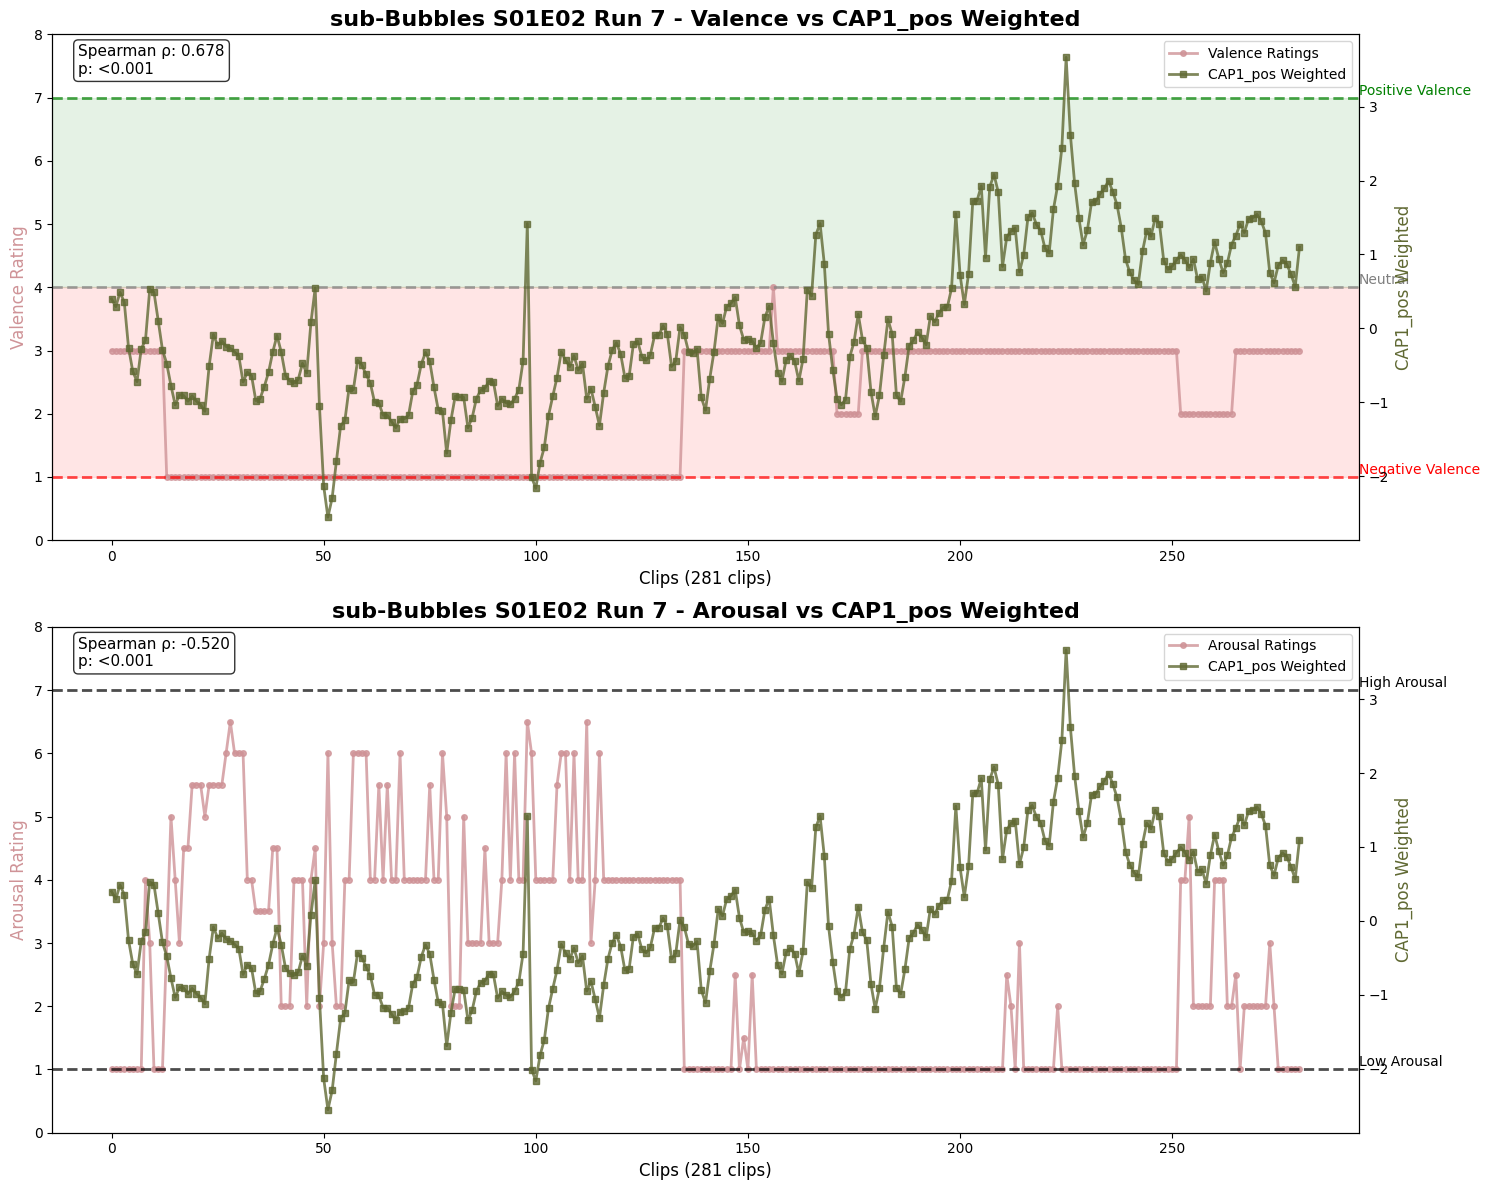

    Run 7 CAP1_pos: Valence r=0.678 (p=<0.001), Arousal r=-0.520 (p=<0.001)
    Skipping CAP1_neg (|ρ_val|=0.082, |ρ_aro|=-0.021 ≤ 0.6)
    Skipping CAP2_pos (|ρ_val|=-0.355, |ρ_aro|=0.281 ≤ 0.6)
    Figure saved: dset/derivatives/figures/sub-Bubbles_S01E02_run7_CAP2_neg_emotion_correlation.png


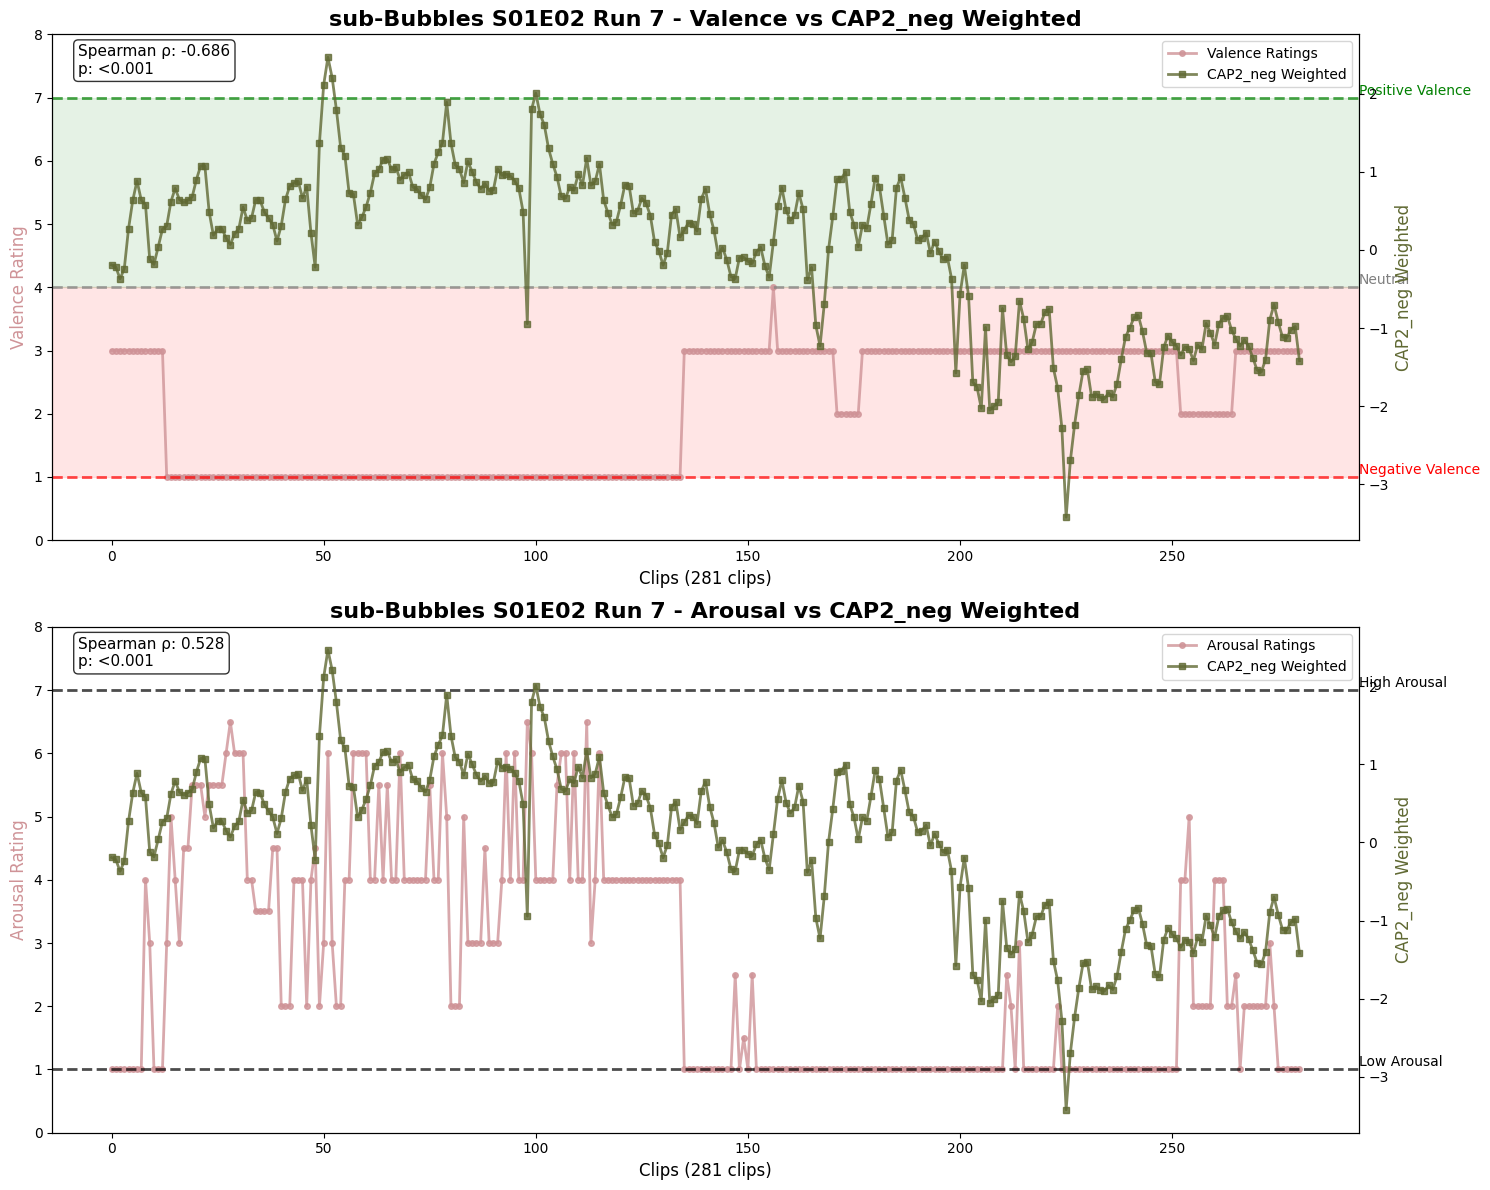

    Run 7 CAP2_neg: Valence r=-0.686 (p=<0.001), Arousal r=0.528 (p=<0.001)
    Skipping CAP3_pos (|ρ_val|=-0.075, |ρ_aro|=0.084 ≤ 0.6)
    Skipping CAP3_neg (|ρ_val|=-0.165, |ρ_aro|=0.156 ≤ 0.6)
    Skipping CAP4_pos (|ρ_val|=0.254, |ρ_aro|=-0.253 ≤ 0.6)
    Skipping CAP4_neg (|ρ_val|=0.149, |ρ_aro|=-0.118 ≤ 0.6)
    Skipping CAP5_pos (|ρ_val|=0.166, |ρ_aro|=-0.156 ≤ 0.6)
    Skipping CAP5_neg (|ρ_val|=0.075, |ρ_aro|=-0.084 ≤ 0.6)

Processing S01E03 - Individual Runs
Loaded CAP data: (529, 10) (timepoints x CAPs)
Loaded emotion data with run info: (1921, 4)
Available runs in emotion data: ['S01E03R01', 'S01E03R02', 'S01E03R03', 'S01E03R04', 'S01E03R05', 'S01E03R06']
Using 529 timepoints for analysis

Processing S01E03 - Run 1
    Found 261 clips for run S01E03R01
    Run 1 data: 261 valence, 261 arousal, 261 CAP timepoints
    Skipping CAP1_pos (|ρ_val|=0.029, |ρ_aro|=-0.255 ≤ 0.6)
    Skipping CAP1_neg (|ρ_val|=0.046, |ρ_aro|=-0.284 ≤ 0.6)
    Skipping CAP2_pos (|ρ_val|=-0.148, |ρ_ar

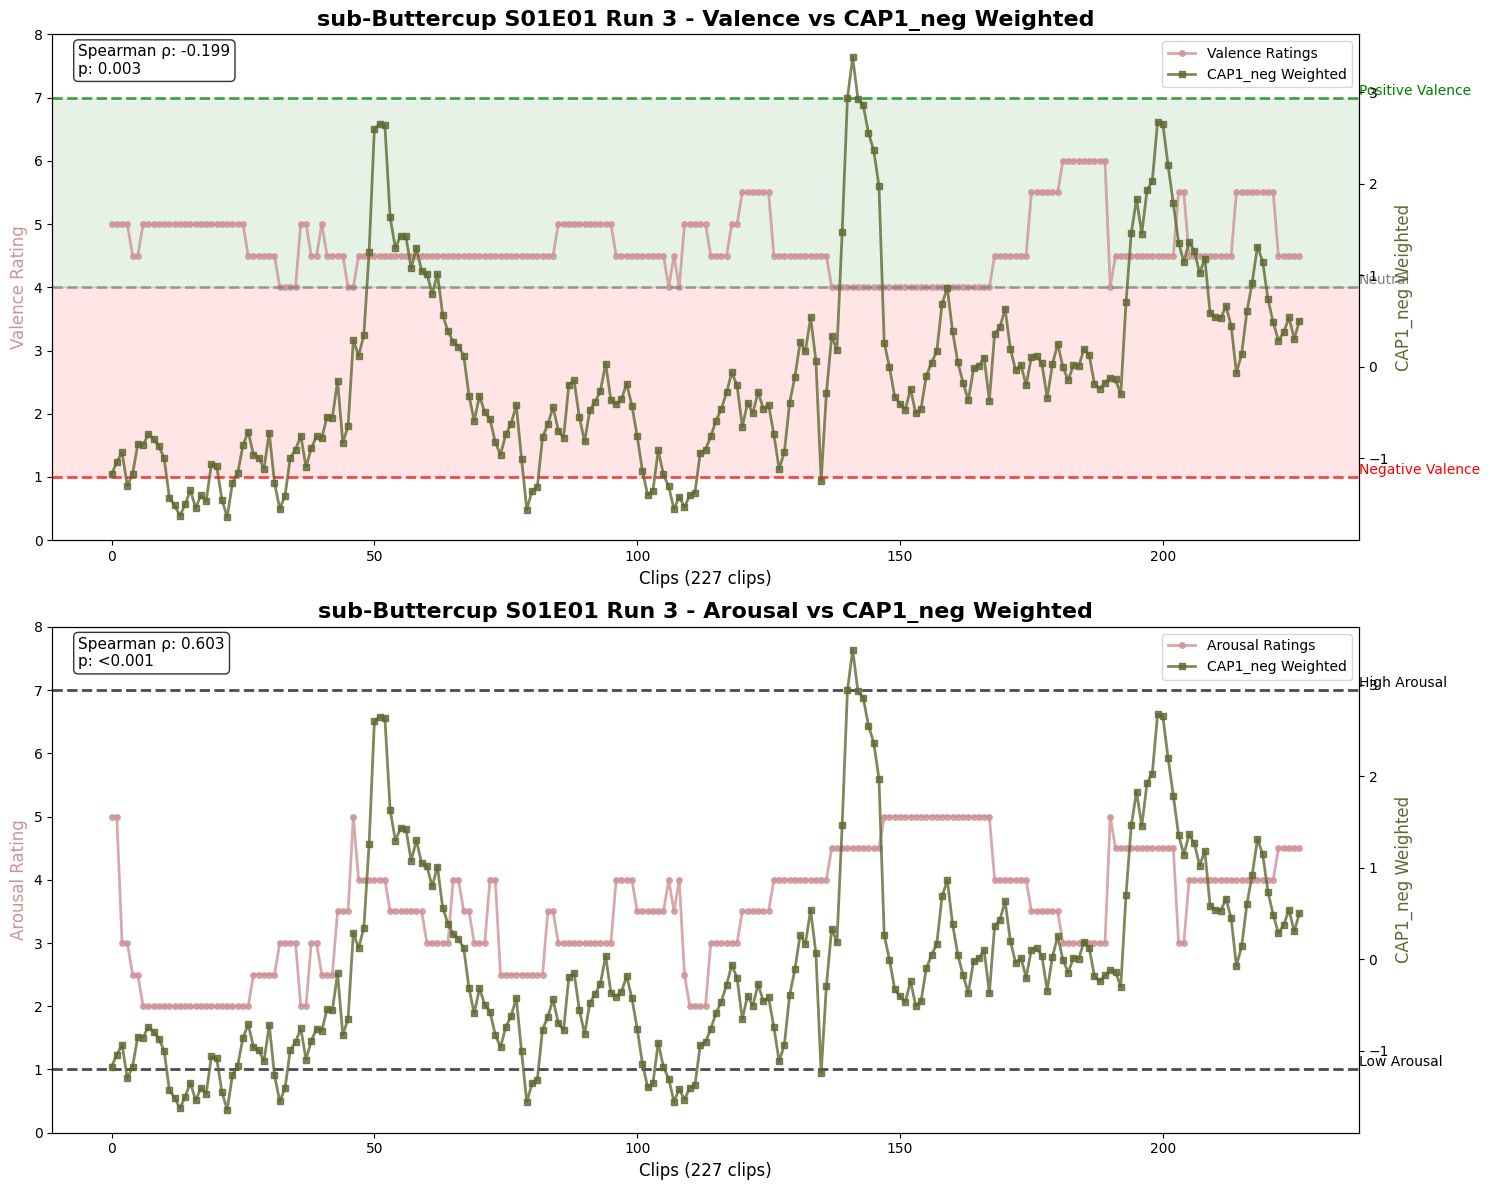

    Run 3 CAP1_neg: Valence r=-0.199 (p=0.003), Arousal r=0.603 (p=<0.001)
    Figure saved: dset/derivatives/figures/sub-Buttercup_S01E01_run3_CAP2_pos_emotion_correlation.png


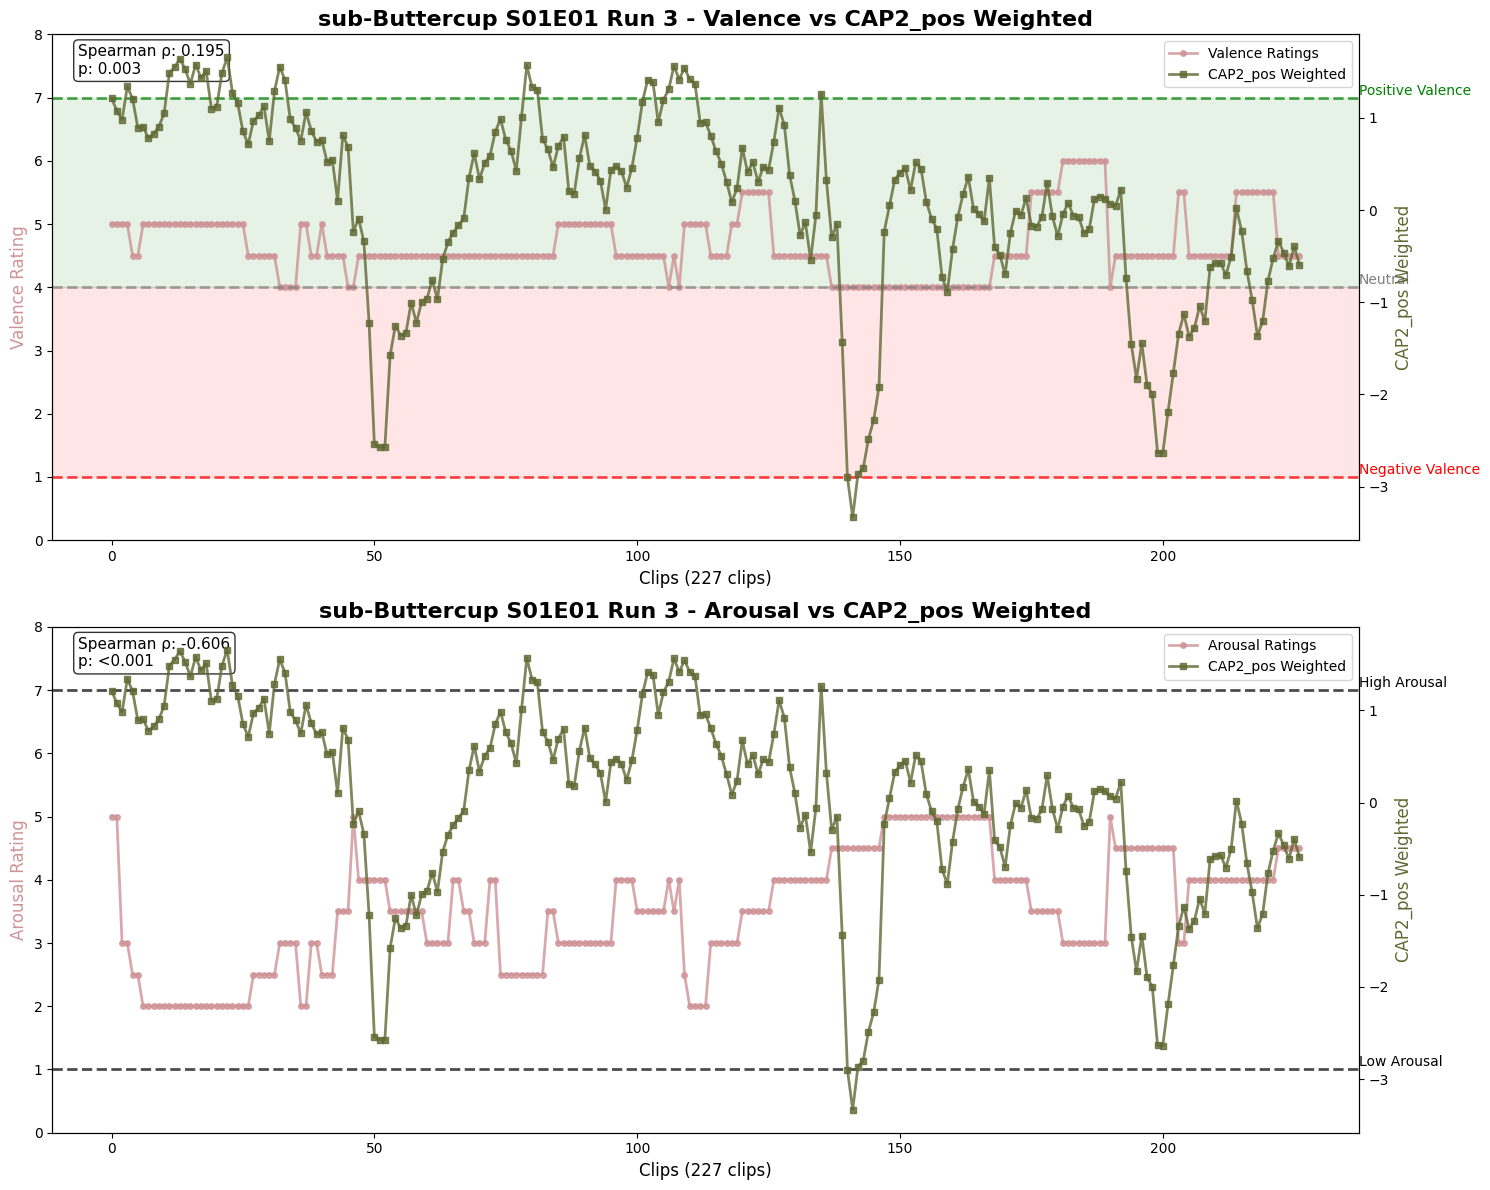

    Run 3 CAP2_pos: Valence r=0.195 (p=0.003), Arousal r=-0.606 (p=<0.001)
    Skipping CAP2_neg (|ρ_val|=0.136, |ρ_aro|=-0.401 ≤ 0.6)
    Skipping CAP3_pos (|ρ_val|=-0.097, |ρ_aro|=0.287 ≤ 0.6)
    Figure saved: dset/derivatives/figures/sub-Buttercup_S01E01_run3_CAP3_neg_emotion_correlation.png


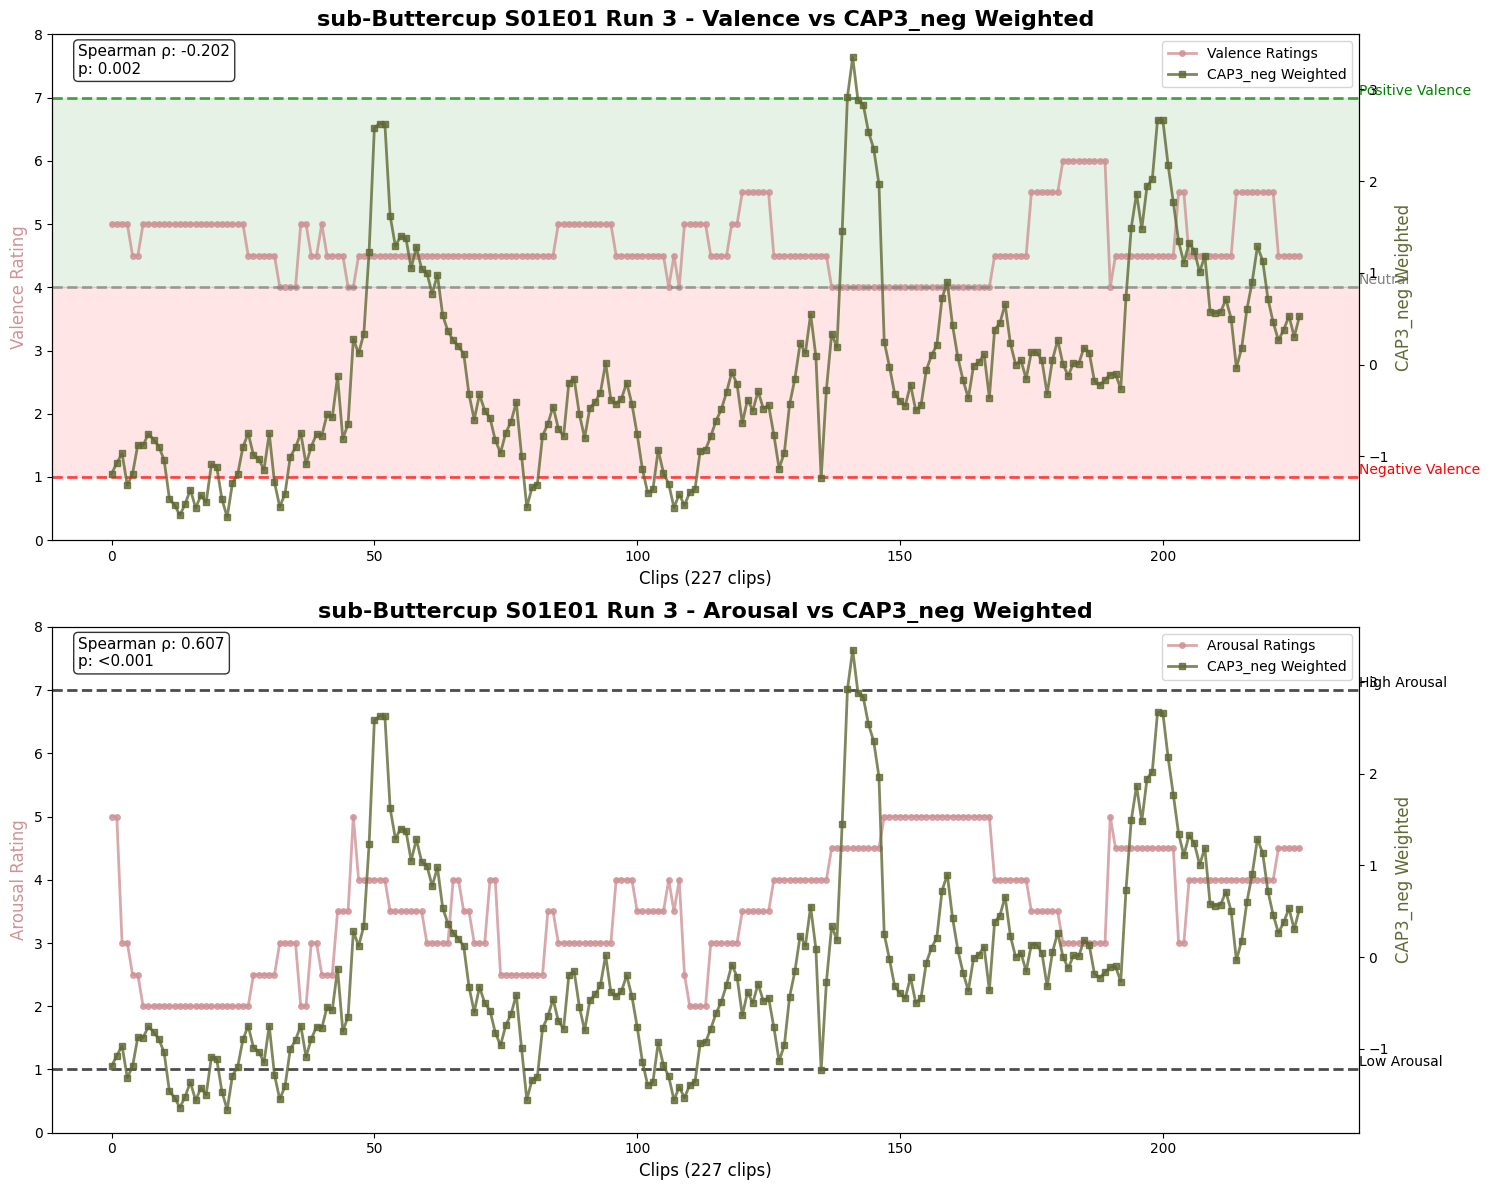

    Run 3 CAP3_neg: Valence r=-0.202 (p=0.002), Arousal r=0.607 (p=<0.001)
    Figure saved: dset/derivatives/figures/sub-Buttercup_S01E01_run3_CAP4_pos_emotion_correlation.png


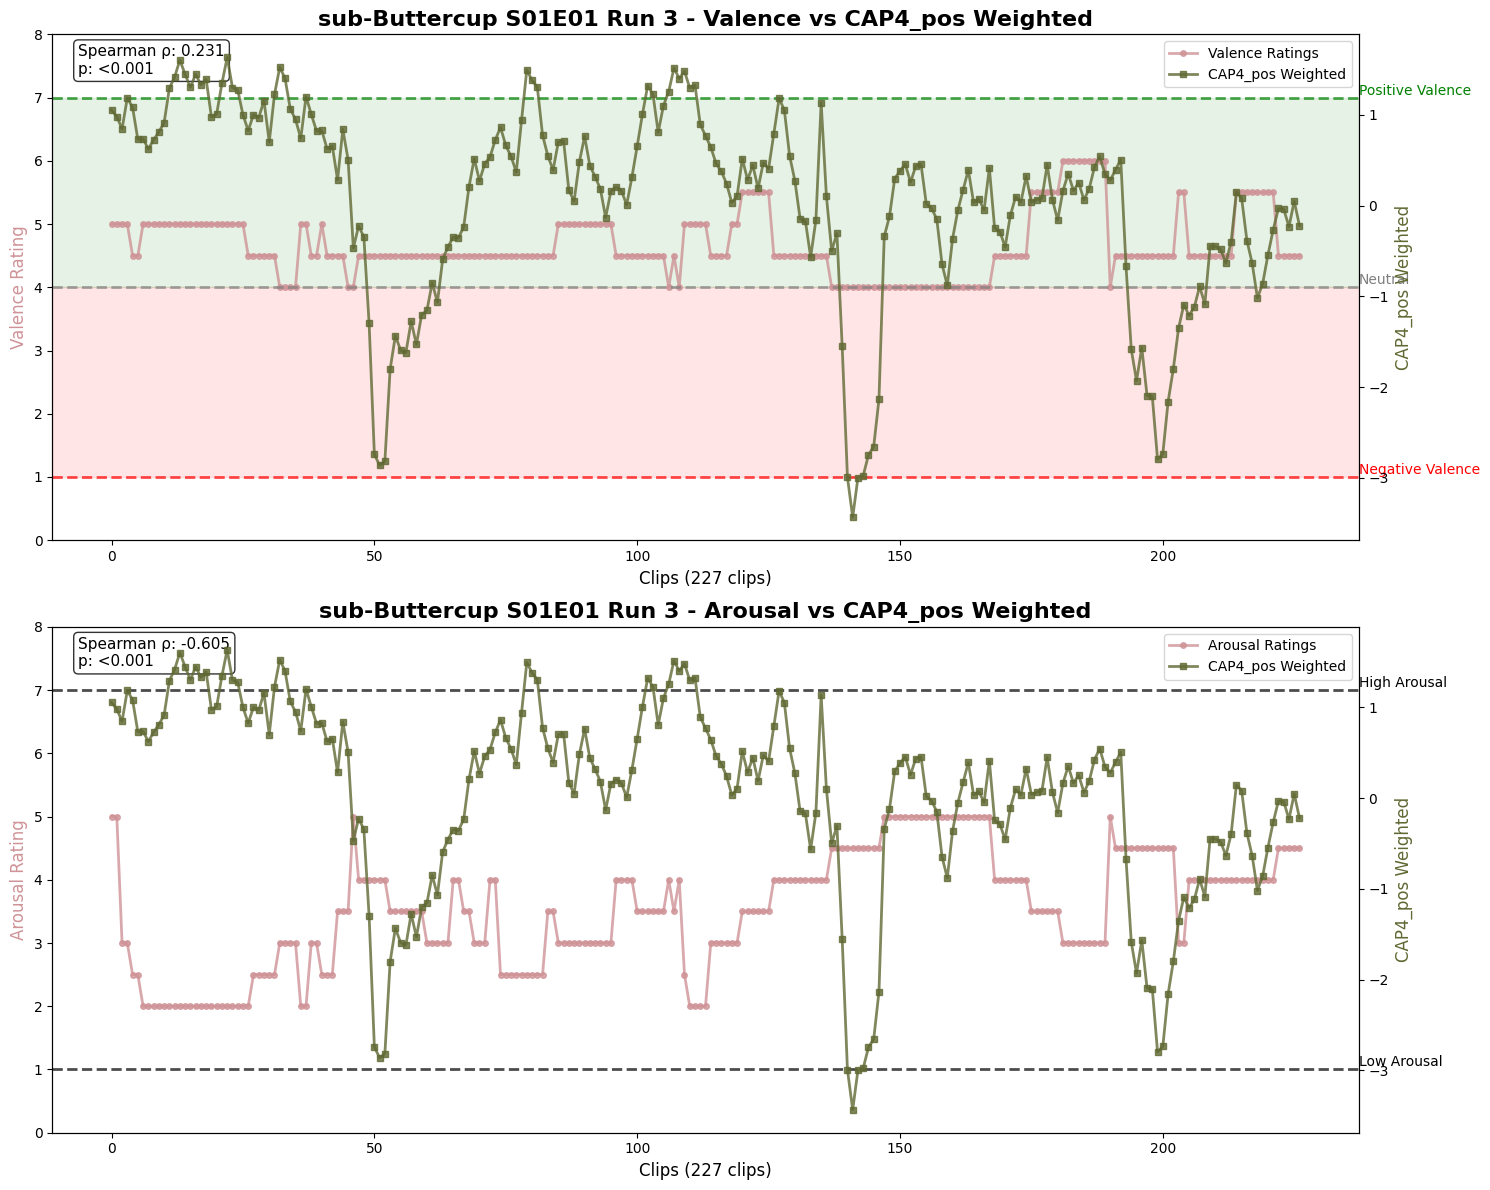

    Run 3 CAP4_pos: Valence r=0.231 (p=<0.001), Arousal r=-0.605 (p=<0.001)
    Skipping CAP4_neg (|ρ_val|=-0.088, |ρ_aro|=0.598 ≤ 0.6)

Processing S01E02 - Individual Runs
Loaded CAP data: (2004, 8) (timepoints x CAPs)
Loaded emotion data with run info: (2004, 4)
Available runs in emotion data: ['S01E02R01', 'S01E02R02', 'S01E02R03', 'S01E02R04', 'S01E02R05', 'S01E02R06', 'S01E02R07']
Using 2004 timepoints for analysis

Processing S01E02 - Run 1
    Found 303 clips for run S01E02R01
    Run 1 data: 303 valence, 303 arousal, 303 CAP timepoints
    Skipping CAP1_pos (|ρ_val|=0.033, |ρ_aro|=0.019 ≤ 0.6)
    Skipping CAP1_neg (|ρ_val|=-0.259, |ρ_aro|=-0.039 ≤ 0.6)
    Skipping CAP2_pos (|ρ_val|=0.263, |ρ_aro|=0.032 ≤ 0.6)
    Skipping CAP2_neg (|ρ_val|=-0.004, |ρ_aro|=0.008 ≤ 0.6)
    Skipping CAP3_pos (|ρ_val|=0.125, |ρ_aro|=0.098 ≤ 0.6)
    Skipping CAP3_neg (|ρ_val|=-0.257, |ρ_aro|=-0.026 ≤ 0.6)
    Skipping CAP4_pos (|ρ_val|=0.241, |ρ_aro|=0.049 ≤ 0.6)
    Skipping CAP4_neg (|ρ_val|=-

/var/folders/w7/tr80j6dx7kz1xqvddnxtqtzr0000gn/T/ipykernel_37447/495858956.py:76: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  val_corr, val_p = spearmanr(cap_timeseries, run_valence)


    Figure saved: dset/derivatives/figures/sub-Buttercup_S01E04_run2_CAP3_pos_emotion_correlation.png


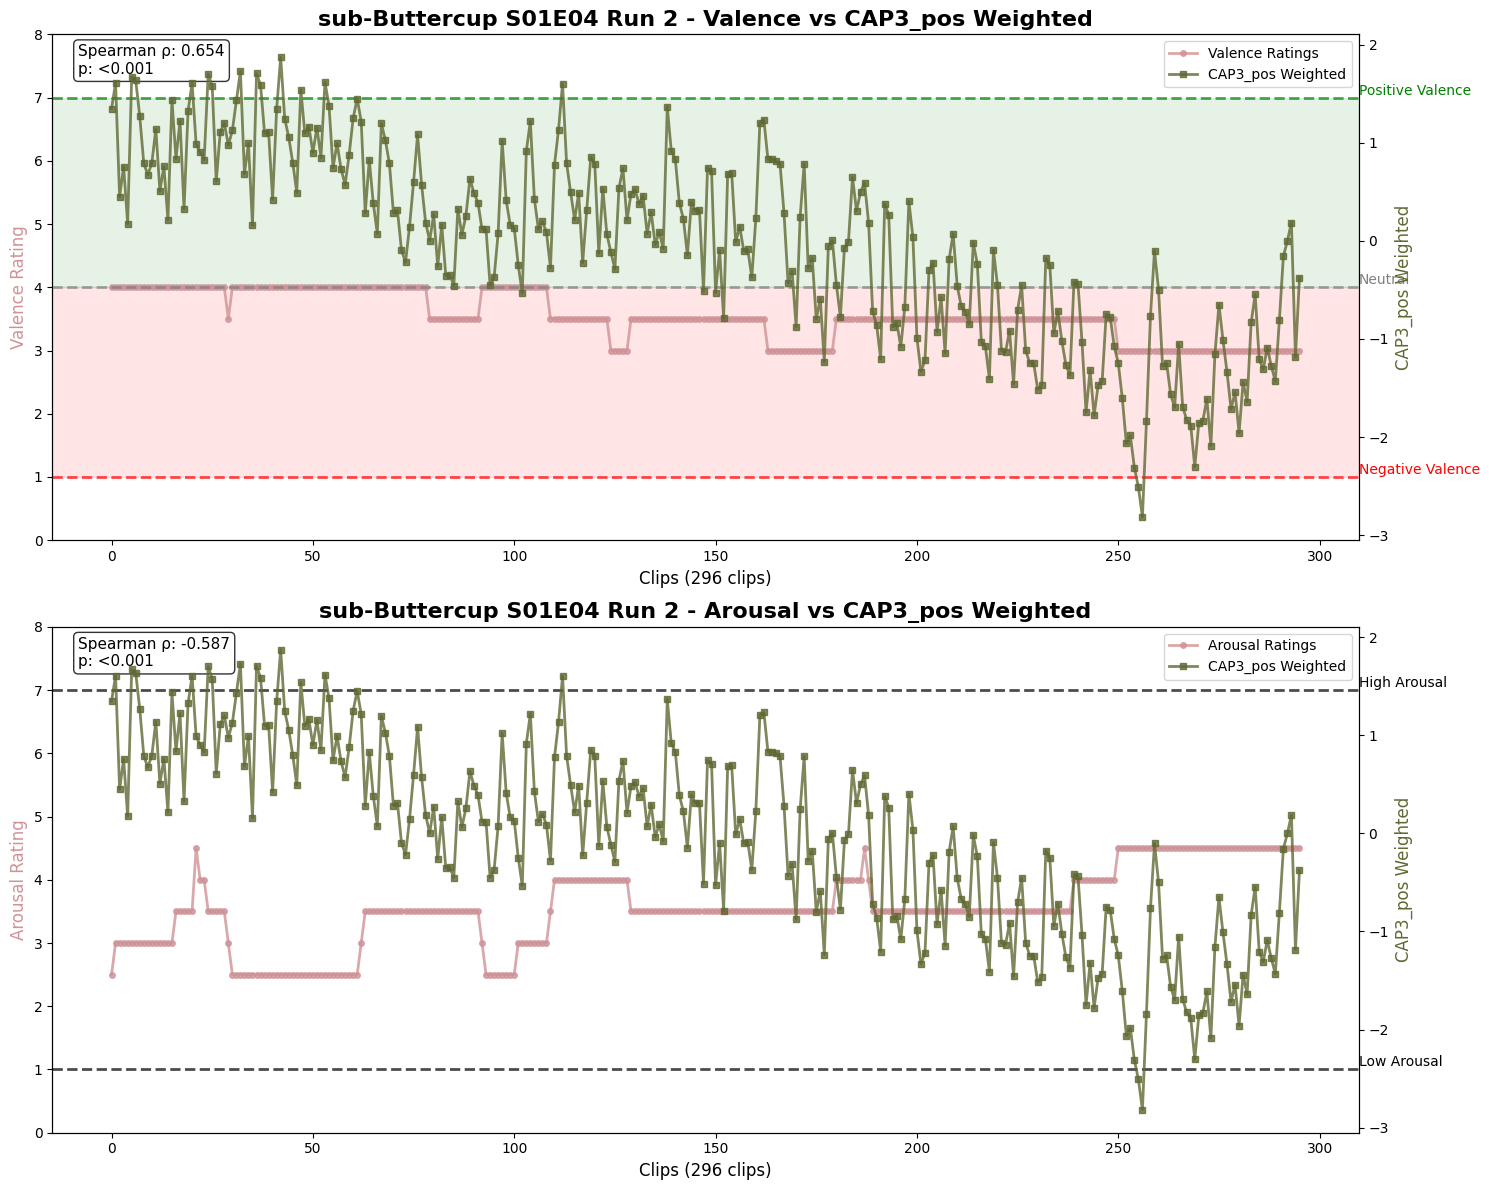

    Run 2 CAP3_pos: Valence r=0.654 (p=<0.001), Arousal r=-0.587 (p=<0.001)
    Skipping CAP3_neg (|ρ_val|=-0.223, |ρ_aro|=0.045 ≤ 0.6)
    Skipping CAP4_pos (|ρ_val|=0.285, |ρ_aro|=-0.087 ≤ 0.6)
    Skipping CAP4_neg (|ρ_val|=-0.587, |ρ_aro|=0.518 ≤ 0.6)

Processing S01E04 - Run 3
    Found 293 clips for run S01E04R03
    Run 3 data: 293 valence, 293 arousal, 293 CAP timepoints
    Skipping CAP1_pos (|ρ_val|=0.004, |ρ_aro|=-0.149 ≤ 0.6)
    Skipping CAP1_neg (|ρ_val|=0.043, |ρ_aro|=0.118 ≤ 0.6)
    Skipping CAP2_pos (|ρ_val|=-0.037, |ρ_aro|=-0.107 ≤ 0.6)
    Skipping CAP2_neg (|ρ_val|=0.021, |ρ_aro|=0.147 ≤ 0.6)
    Skipping CAP3_pos (|ρ_val|=-0.118, |ρ_aro|=-0.371 ≤ 0.6)
    Skipping CAP3_neg (|ρ_val|=0.033, |ρ_aro|=0.083 ≤ 0.6)
    Skipping CAP4_pos (|ρ_val|=-0.033, |ρ_aro|=-0.052 ≤ 0.6)
    Skipping CAP4_neg (|ρ_val|=0.097, |ρ_aro|=0.511 ≤ 0.6)

Processing S01E04 - Run 4
    Found 318 clips for run S01E04R04
    Run 4 data: 318 valence, 318 arousal, 318 CAP timepoints
    Skipping 

In [7]:
# Plot CAP weighted timeseries with emotion ratings BY INDIVIDUAL RUNS
print("Processing CAP timeseries by individual runs using combined data...")

for sub_id, episodes in participant_data.items():
    print(f"\n{'='*80}")
    print(f"PLOTTING {sub_id} - BY RUNS")
    print(f"{'='*80}")

    for episode_key, run_numbers in episodes.items():
        # Handle both episode naming conventions
        if episode_key.startswith('S01E'):
            ep_num = int(episode_key[-2:])  # Extract from S01E02
        else:
            ep_num = int(episode_key.split('_')[1])  # Extract from episode_2
        
        print(f"\n{'='*60}")
        print(f"Processing {episode_key} - Individual Runs")
        print(f"{'='*60}")

        # Load combined CAP timeseries data that we already computed
        combined_csv_path = OUT_DIR / f"{sub_id}_{episode_key}_all_caps_timeseries.csv"
        emotion_csv_path = RELI_DIR / f"S01E{ep_num:02d}_avg.csv"
        
        if not combined_csv_path.exists():
            print(f"Warning: Combined CAP data not found at {combined_csv_path}")
            continue
            
        if not emotion_csv_path.exists():
            print(f"Warning: Emotion data not found at {emotion_csv_path}")
            continue
        
        # Load the data
        caps_df = pd.read_csv(combined_csv_path)
        emotion_df = pd.read_csv(emotion_csv_path)
        
        print(f"Loaded CAP data: {caps_df.shape} (timepoints x CAPs)")
        print(f"Loaded emotion data with run info: {emotion_df.shape}")
        print(f"Available runs in emotion data: {sorted(emotion_df['run'].unique())}")
        
        # Ensure same length across all data
        min_length = min(len(emotion_df), len(caps_df))
        emotion_df_trimmed = emotion_df.iloc[:min_length]
        caps_df_trimmed = caps_df.iloc[:min_length]
        
        print(f"Using {min_length} timepoints for analysis")
        
        # Process each run individually
        for run_num in run_numbers:
            print(f"\n{'='*50}")
            print(f"Processing {episode_key} - Run {run_num}")
            print(f"{'='*50}")
            
            # Get rows for this specific run from emotion data
            run_identifier = f"{episode_key}R{run_num:02d}"
            run_mask = emotion_df_trimmed['run'] == run_identifier
            
            if not run_mask.any():
                print(f"    Warning: No data found for run {run_identifier}")
                continue
            
            # Extract data for this run using the mask
            run_emotion_data = emotion_df_trimmed[run_mask].reset_index(drop=True)
            run_caps_data = caps_df_trimmed[run_mask].reset_index(drop=True)
            
            run_valence = run_emotion_data['valence']
            run_arousal = run_emotion_data['arousal']
            
            print(f"    Found {len(run_emotion_data)} clips for run {run_identifier}")
            print(f"    Run {run_num} data: {len(run_valence)} valence, {len(run_arousal)} arousal, {len(run_caps_data)} CAP timepoints")
            
            # Plot each CAP for this run
            for cap_name in run_caps_data.columns:
                cap_timeseries = run_caps_data[cap_name]
                
                # Calculate correlations
                val_corr, val_p = spearmanr(cap_timeseries, run_valence)
                aro_corr, aro_p = spearmanr(cap_timeseries, run_arousal)

                # Only plot if either |rho| exceeds threshold (treat NaN as not passing)
                if not (passes_threshold(val_corr) or passes_threshold(aro_corr)):
                    # Format safely even if NaN
                    val_str = "nan" if not np.isfinite(val_corr) else f"{val_corr:.3f}"
                    aro_str = "nan" if not np.isfinite(aro_corr) else f"{aro_corr:.3f}"
                    print(f"    Skipping {cap_name} (|ρ_val|={val_str}, |ρ_aro|={aro_str} ≤ {PLOT_ABS_R_THRESHOLD})")
                    continue

                # Create the plot
                fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 12))
                
                # Define colors
                colors = ['#CF9397', "#606933", '#E5D28E']
                
                # Valence plot
                ax1.axhspan(1, 4, alpha=0.1, color='red', zorder=0)
                ax1.axhspan(4, 7, alpha=0.1, color='green', zorder=0)
                
                # Plot valence ratings
                ax1.plot(range(len(run_valence)), run_valence, color=colors[0], marker='o', markersize=4, 
                         linewidth=2, alpha=0.8, label='Valence Ratings')
                
                # Plot CAP weighted timeseries on secondary y-axis
                ax1_twin = ax1.twinx()
                ax1_twin.plot(range(len(cap_timeseries)), cap_timeseries, color=colors[1], marker='s', markersize=4, 
                              linewidth=2, alpha=0.8, label=f'{cap_name} Weighted')
                
                ax1.set_title(f'{sub_id} {episode_key} Run {run_num} - Valence vs {cap_name} Weighted', fontsize=16, fontweight='bold')
                ax1.set_xlabel(f'Clips ({len(run_valence)} clips)', fontsize=12)
                ax1.set_ylabel('Valence Rating', fontsize=12, color=colors[0])
                ax1_twin.set_ylabel(f'{cap_name} Weighted', fontsize=12, color=colors[1])
                ax1.set_ylim(0, 8)
                
                # Add reference lines for valence
                ax1.axhline(y=1, color='red', linestyle='--', alpha=0.7, linewidth=2)
                ax1.axhline(y=4, color='gray', linestyle='--', alpha=0.7, linewidth=2)
                ax1.axhline(y=7, color='green', linestyle='--', alpha=0.7, linewidth=2)
                
                # Add text labels
                x_right = ax1.get_xlim()[1]
                ax1.text(x_right, 1, 'Negative Valence', ha='left', va='bottom', fontsize=10, color='red')
                ax1.text(x_right, 4, 'Neutral', ha='left', va='bottom', fontsize=10, color='gray')
                ax1.text(x_right, 7, 'Positive Valence', ha='left', va='bottom', fontsize=10, color='green')
                
                # Combined legend
                lines1, labels1 = ax1.get_legend_handles_labels()
                lines2, labels2 = ax1_twin.get_legend_handles_labels()
                ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper right')
                
                # Add correlation results (safe formatting)
                val_p_str = "nan" if not np.isfinite(val_p) else (f"{val_p:.3f}" if val_p >= 0.001 else "<0.001")
                val_corr_str = "nan" if not np.isfinite(val_corr) else f"{val_corr:.3f}"
                ax1.text(0.02, 0.98, f"Spearman ρ: {val_corr_str}\np: {val_p_str}",
                         transform=ax1.transAxes,
                         fontsize=11, verticalalignment='top', horizontalalignment='left',
                         bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.8))

                # Arousal plot  
                ax2.plot(range(len(run_arousal)), run_arousal, color=colors[0], marker='o', markersize=4, 
                         linewidth=2, alpha=0.8, label='Arousal Ratings')
                
                # Plot CAP weighted timeseries on secondary y-axis
                ax2_twin = ax2.twinx()
                ax2_twin.plot(range(len(cap_timeseries)), cap_timeseries, color=colors[1], marker='s', markersize=4, 
                              linewidth=2, alpha=0.8, label=f'{cap_name} Weighted')
                
                ax2.set_title(f'{sub_id} {episode_key} Run {run_num} - Arousal vs {cap_name} Weighted', fontsize=16, fontweight='bold')
                ax2.set_xlabel(f'Clips ({len(run_arousal)} clips)', fontsize=12)
                ax2.set_ylabel('Arousal Rating', fontsize=12, color=colors[0])
                ax2_twin.set_ylabel(f'{cap_name} Weighted', fontsize=12, color=colors[1])
                ax2.set_ylim(0, 8)
                
                # Add reference lines for arousal
                ax2.axhline(y=1, color='black', linestyle='--', alpha=0.7, linewidth=2)
                ax2.axhline(y=7, color='black', linestyle='--', alpha=0.7, linewidth=2)
                
                # Add text labels
                x_right = ax2.get_xlim()[1]
                ax2.text(x_right, 1, 'Low Arousal', ha='left', va='bottom', fontsize=10, color='black')
                ax2.text(x_right, 7, 'High Arousal', ha='left', va='bottom', fontsize=10, color='black')
                
                # Combined legend
                lines1, labels1 = ax2.get_legend_handles_labels()
                lines2, labels2 = ax2_twin.get_legend_handles_labels()
                ax2.legend(lines1 + lines2, labels1 + labels2, loc='upper right')
                
                # Add correlation results (safe formatting)
                aro_p_str = "nan" if not np.isfinite(aro_p) else (f"{aro_p:.3f}" if aro_p >= 0.001 else "<0.001")
                aro_corr_str = "nan" if not np.isfinite(aro_corr) else f"{aro_corr:.3f}"
                ax2.text(0.02, 0.98, f"Spearman ρ: {aro_corr_str}\np: {aro_p_str}",
                         transform=ax2.transAxes,
                         fontsize=11, verticalalignment='top', horizontalalignment='left',
                         bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.8))

                plt.tight_layout()
                
                # Save figure with run-specific filename
                figure_filename = f"{sub_id}_{episode_key}_run{run_num}_{cap_name}_emotion_correlation.png"
                figure_path = FIGURES_DIR / figure_filename
                fig.savefig(figure_path, dpi=300, bbox_inches='tight', facecolor='white')
                print(f"    Figure saved: {figure_path}")
                
                plt.show()
                
                print(f"    Run {run_num} {cap_name}: Valence r={val_corr_str} (p={val_p_str}), Arousal r={aro_corr_str} (p={aro_p_str})")

print(f"\n{'='*80}")
print("ALL RUN-LEVEL PLOTTING COMPLETE")
print(f"{'='*80}")
